<a href="https://colab.research.google.com/github/pragya-gupta7/time-series-classification-using-ssl/blob/main/Time_series_based_self_supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision numpy matplotlib

<ipython-input-67-f5c1b95c8034>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  har_data = torch.load('har/train.pt')
<ipython-input-67-f5c1b95c8034>:8: FutureWarning: You 

HAR Samples Shape: torch.Size([5881, 3, 206])
Gesture Samples Shape: torch.Size([320, 3, 206])
HAR NaNs: 0
HAR Infs: 0
Gesture NaNs: 0
Gesture Infs: 0

Summary for HAR Dataset:
Mean: [0.49958095 0.01789008 0.05485199]
Std Dev: [0.50867283 0.30838495 0.28630674]
Min: [-0.4665558 -1.582079  -1.639609 ]
Max: [2.157473 1.21735  1.281363]

Summary for Gesture Dataset:
Mean: [0.03474551 0.03474551 0.03474551]
Std Dev: [0.98069556 0.98069556 0.98069556]
Min: [-3.24 -3.24 -3.24]
Max: [3.4157 3.4157 3.4157]


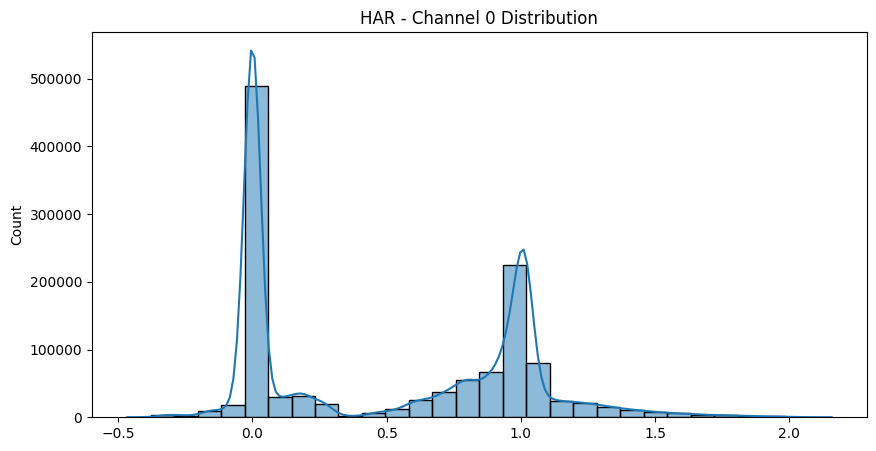

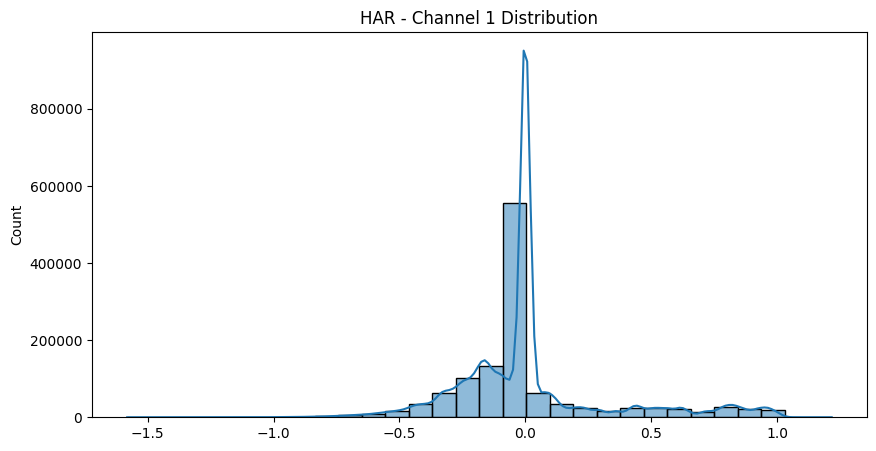

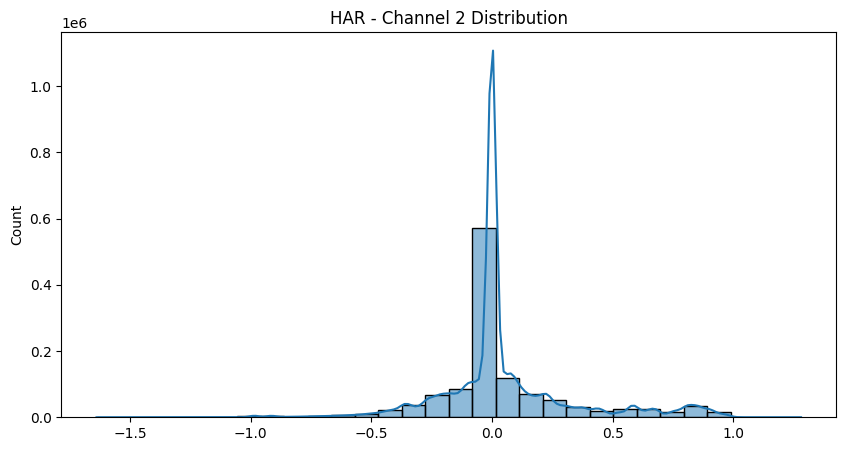

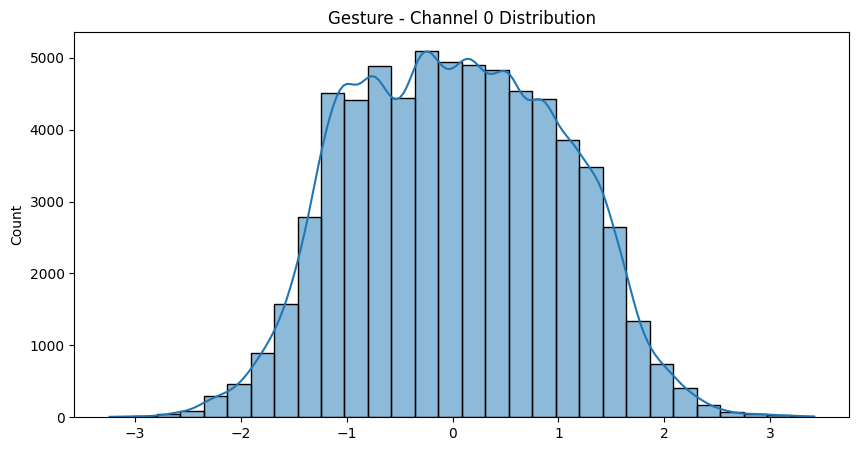

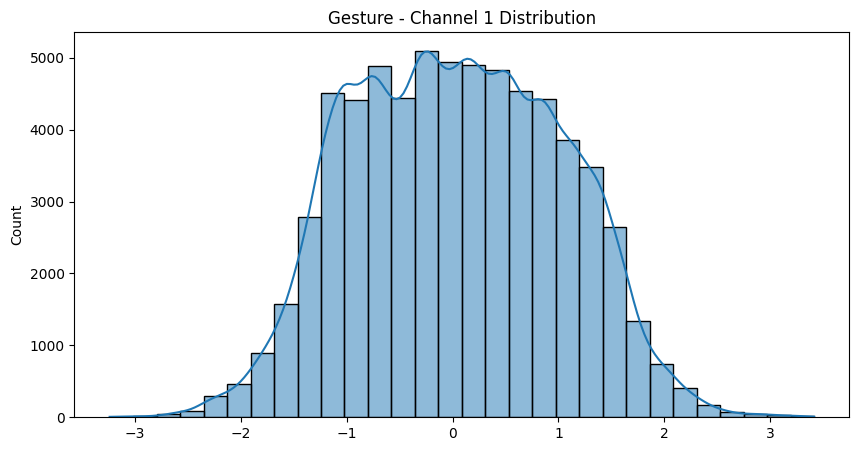

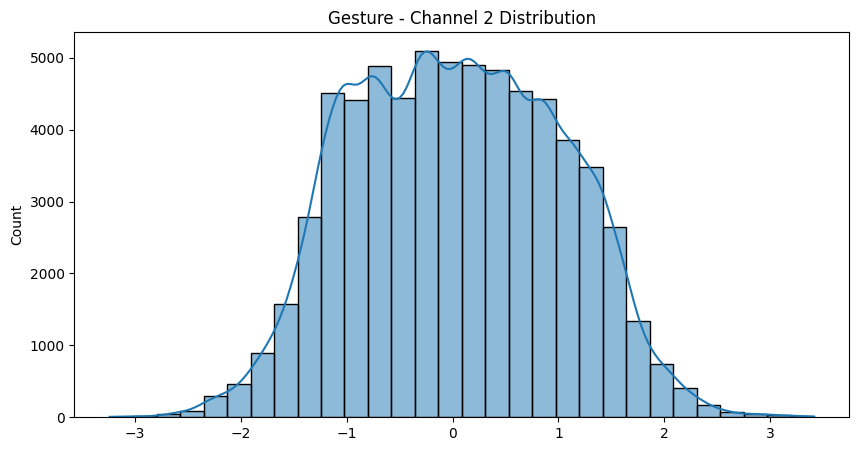

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets again for consistency
har_data = torch.load('har/train.pt')
gesture_data = torch.load('gesture/train.pt')

# Extract samples and labels
har_samples = har_data['samples']
gesture_samples = gesture_data['samples']

har_labels = har_data['labels']
gesture_labels = gesture_data['labels']

# Check shapes
print(f"HAR Samples Shape: {har_samples.shape}")
print(f"Gesture Samples Shape: {gesture_samples.shape}")

# Convert to NumPy for easier processing
har_np = har_samples.numpy()
gesture_np = gesture_samples.numpy()

# 1. Check for NaNs or Infinite values
print("HAR NaNs:", np.isnan(har_np).sum())
print("HAR Infs:", np.isinf(har_np).sum())

print("Gesture NaNs:", np.isnan(gesture_np).sum())
print("Gesture Infs:", np.isinf(gesture_np).sum())

# 2. Statistical Summary
def summarize_data(data, dataset_name):
    print(f"\nSummary for {dataset_name} Dataset:")
    print(f"Mean: {np.mean(data, axis=(0, 2))}")  # mean per channel
    print(f"Std Dev: {np.std(data, axis=(0, 2))}")
    print(f"Min: {np.min(data, axis=(0, 2))}")
    print(f"Max: {np.max(data, axis=(0, 2))}")

summarize_data(har_np, "HAR")
summarize_data(gesture_np, "Gesture")

# 3. Visualize Distributions (Per Channel)
def plot_distributions(data, dataset_name, num_channels=3):
    for i in range(num_channels):
        plt.figure(figsize=(10, 5))
        sns.histplot(data[:, i, :].flatten(), kde=True, bins=30)
        plt.title(f'{dataset_name} - Channel {i} Distribution')
        plt.show()

plot_distributions(har_np, "HAR")
plot_distributions(gesture_np, "Gesture")


## Key Insights
#### HAR vs. Gesture Scaling Differences:

<li> HAR's Channel 1 has a mean close to 0.5, while Gesture is centered near 0.
<li> Gesture has a wider range compared to HAR.

#### Preprocessing Need:

<li> Normalization/Standardization: Necessary to bring both datasets to a similar scale, especially since gesture data spans a larger range.
<li> Consistent scaling across datasets will help the model generalize better.

## Detailed Information Extracted from the Plots
### HAR Dataset:

#### Channel 0:
Multimodal distribution with three distinct peaks, suggesting multiple underlying patterns or activities.
Right-skewed, indicating a longer tail towards higher values.
Potential outliers at the extreme ends.
#### Channel 1:
Multimodal distribution with three distinct peaks, suggesting multiple underlying patterns or activities.
Right-skewed, indicating a longer tail towards higher values.
Potential outliers at the extreme ends.
#### Channel 2:
Unimodal distribution with a single peak, indicating a relatively homogeneous distribution.
Right-skewed, indicating a longer tail towards higher values.
Potential outliers at the extreme ends.
### Gesture Dataset:

Channel 0, 1, and 2:
Approximately normally distributed, indicating a bell-shaped curve with data centered around a specific value.
Slight right-skewness, indicating a slightly longer tail towards higher values.
Potential outliers at the extreme ends.

## Final Preprocessing Pipeline
Here’s the consolidated pipeline:

<li> Segmentation (HAR only) for Channels 0 and 1.
<li> Outlier Handling for both datasets.
<li> Standardization/Normalization using HAR's mean and std.

## Preprocessing Workflow Priority
<li> Peak-Based Segmentation (HAR only).
<li> Min-Max Scaling (HAR and Gesture).
<li> IQR-Based Outlier Handling.
<li> Data Augmentation (Optional, for Gesture).

Apply preprocessing to both training and validation data

In [ ]:
import torch
import numpy as np
from scipy.signal import find_peaks
from sklearn.preprocessing import MinMaxScaler

# Load the data from the specified directories and files
datasets = {
    'HAR': {
        'train': torch.load('har/train.pt'),
        'val': torch.load('har/val.pt'),
        'test': torch.load('har/test.pt')
    },
    'Gesture': {
        'train': torch.load('gesture/train.pt'),
        'val': torch.load('gesture/val.pt'),
        'test': torch.load('gesture/test.pt')
    }
}

# Extract samples and labels
for dataset_name, dataset in datasets.items():
    for split, data in dataset.items():
        dataset[split]['samples'] = data['samples']
        dataset[split]['labels'] = data['labels']

# Step 1: Peak-Based Segmentation for HAR Dataset (Channels 0 and 1 only)
def peak_based_segmentation(samples, channel_indices=[0, 1]):
    for channel in channel_indices:
        for i in range(samples.shape[0]):
            # Flatten each sample in the selected channel, find peaks
            data = samples[i, channel, :].numpy()
            peaks, _ = find_peaks(data, height=0)  # height=0 can be adjusted as needed
            # Apply peak-based segmentation as needed (e.g., select portions around peaks)
            # Here we could segment into multiple sections or otherwise preprocess based on peaks

# Apply peak-based segmentation to HAR train, val datasets only
for split in ['train', 'val']:
    peak_based_segmentation(datasets['HAR'][split]['samples'])

# Step 2: Min-Max Scaling for both HAR and Gesture datasets (excluding test data)
def min_max_scale(samples):
    scaler = MinMaxScaler()
    scaled_data = samples.clone().detach().numpy().reshape(-1, samples.shape[2])  # Reshape to 2D for MinMaxScaler
    scaler.fit(scaled_data)  # Fit on entire dataset
    return torch.tensor(scaler.transform(scaled_data).reshape(samples.shape))  # Reshape back to original

# Apply Min-Max scaling on train and val datasets for both HAR and Gesture (not on test data)
for dataset_name in datasets:
    for split in ['train', 'val']:  # Skipping 'test' for Min-Max scaling
        datasets[dataset_name][split]['samples'] = min_max_scale(datasets[dataset_name][split]['samples'])

# Step 3: IQR-Based Outlier Handling
def iqr_outlier_handling(samples):
    for i in range(samples.shape[1]):  # Channel-wise
        # Reshape to treat each time point as an independent value for IQR calculation
        flattened_channel = samples[:, i, :].reshape(-1)
        q1, q3 = np.percentile(flattened_channel, [25, 75])
        iqr = q3 - q1
        lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr

        # Clip values outside the bounds
        samples[:, i, :] = torch.clamp(samples[:, i, :], lower_bound, upper_bound)
    return samples

# Apply IQR-based outlier handling on train and val datasets for both HAR and Gesture (not on test data)
for dataset_name in datasets:
    for split in ['train', 'val']:  # Skipping 'test' for IQR outlier handling
        datasets[dataset_name][split]['samples'] = iqr_outlier_handling(datasets[dataset_name][split]['samples'])

# Save the preprocessed data back to disk (test data will not be saved with preprocessing)
for dataset_name in datasets:
    for split in ['train', 'val']:  # Saving only train and val data
        torch.save(datasets[dataset_name][split], f'{dataset_name.lower()}/{split}_preprocessed.pt')

print("Preprocessing complete and saved (test data unchanged).")


<ipython-input-68-a221e2b6f80f>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  'train': torch.load('har/train.pt'),
<ipython-input-68-a221e2b6f80f>:10: FutureWarning: You 

Preprocessing complete and saved (test data unchanged).


Visualizing har train data before and after preprocessing


<ipython-input-69-2b256814e937>:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  before_data = torch.load(filepaths[dataset_name][split])
<ipython-input-69-2b256814e937>:67

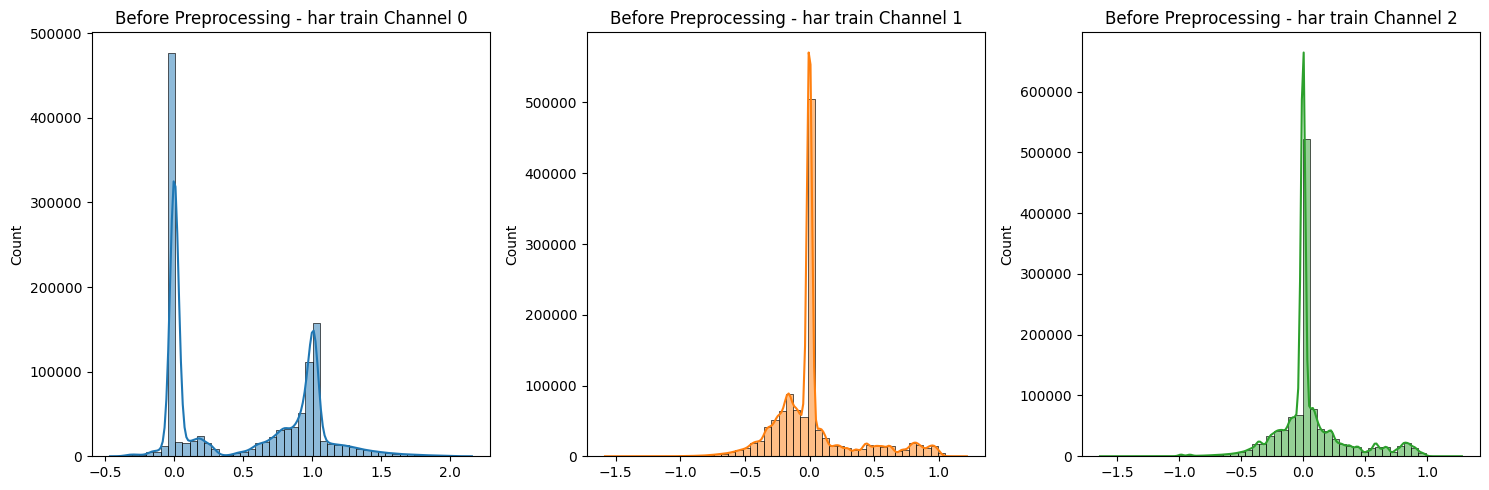

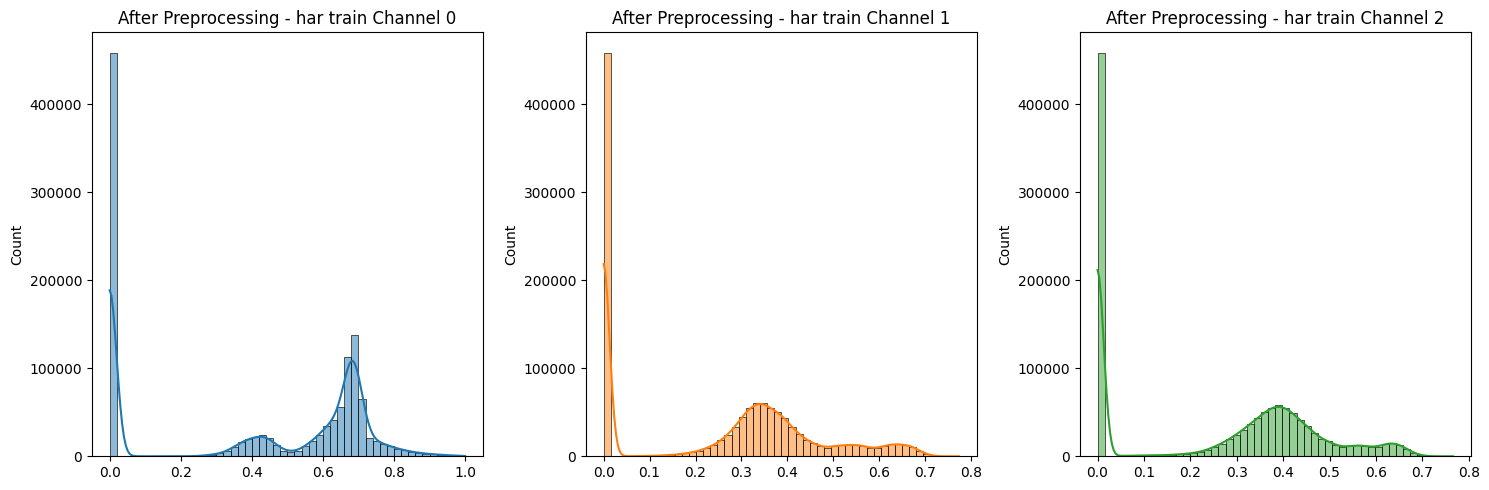

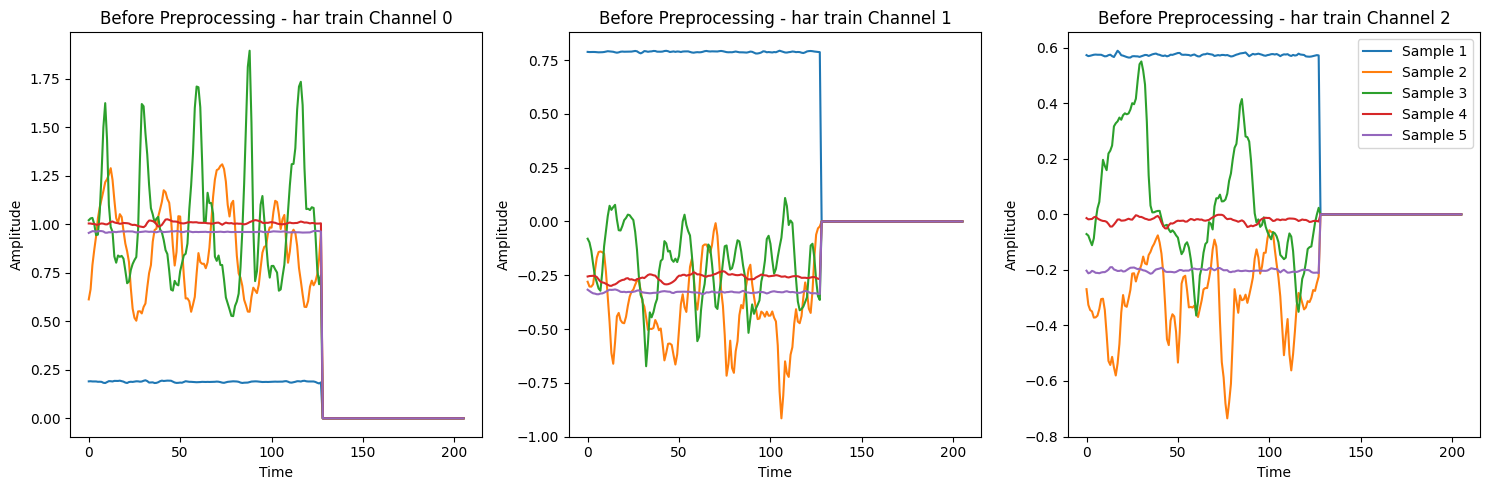

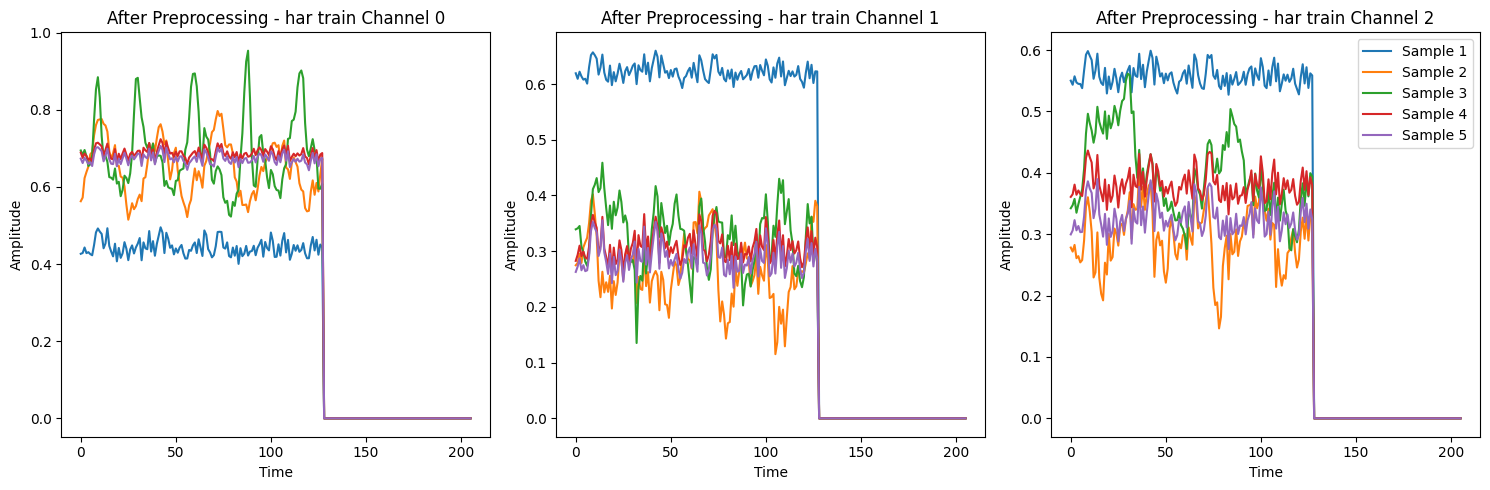

Visualizing har val data before and after preprocessing


<ipython-input-69-2b256814e937>:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  before_data = torch.load(filepaths[dataset_name][split])
<ipython-input-69-2b256814e937>:67

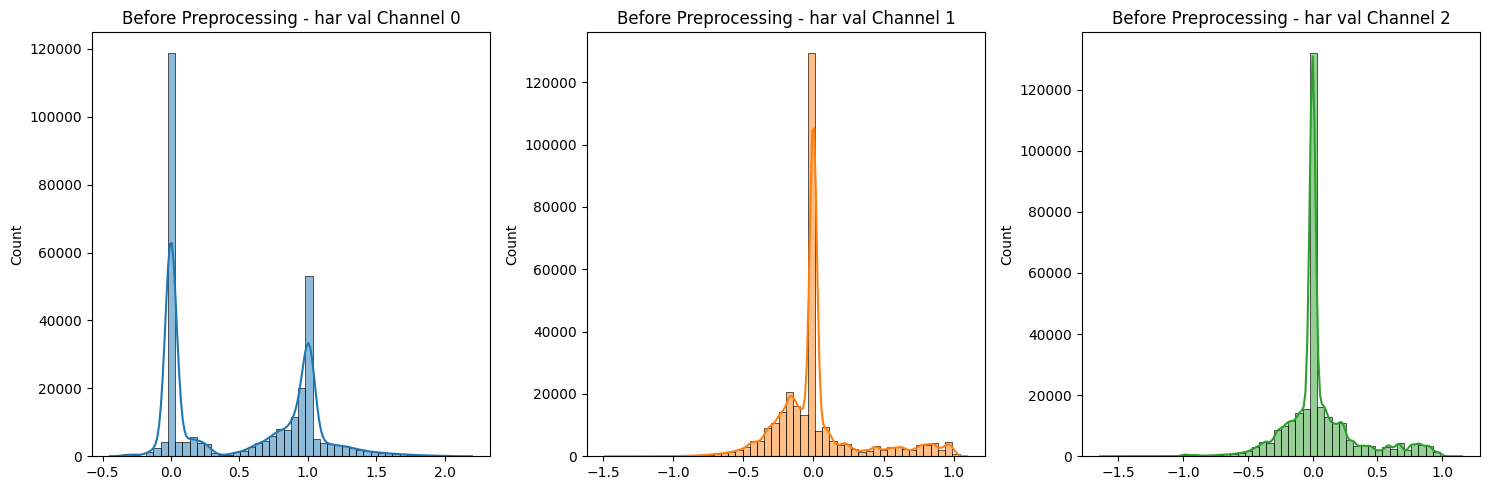

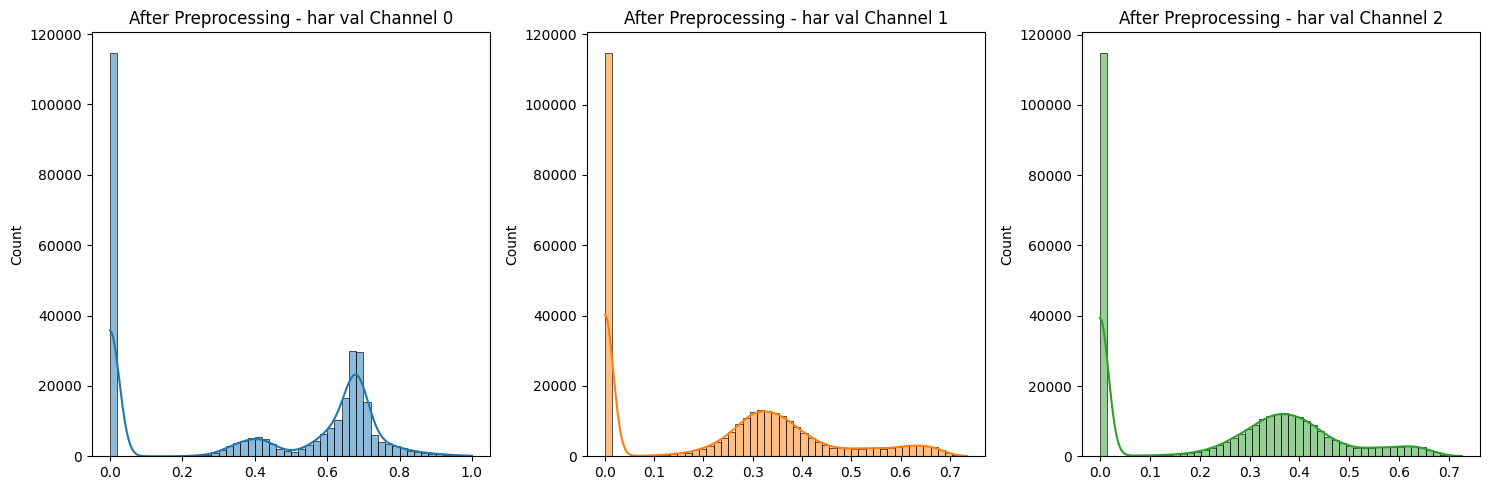

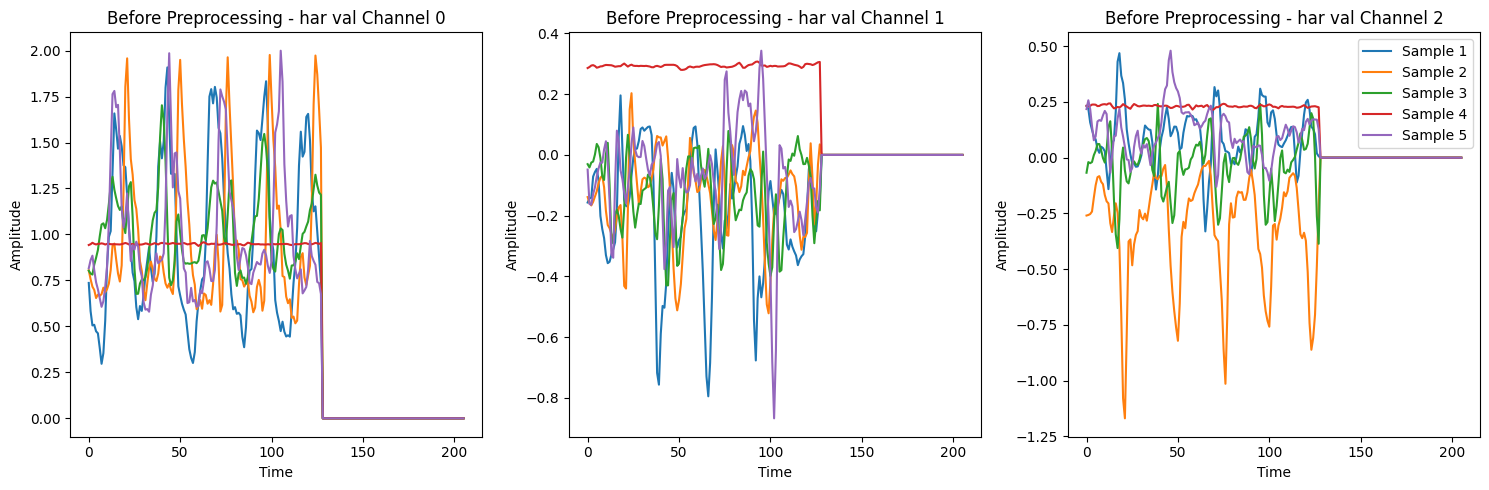

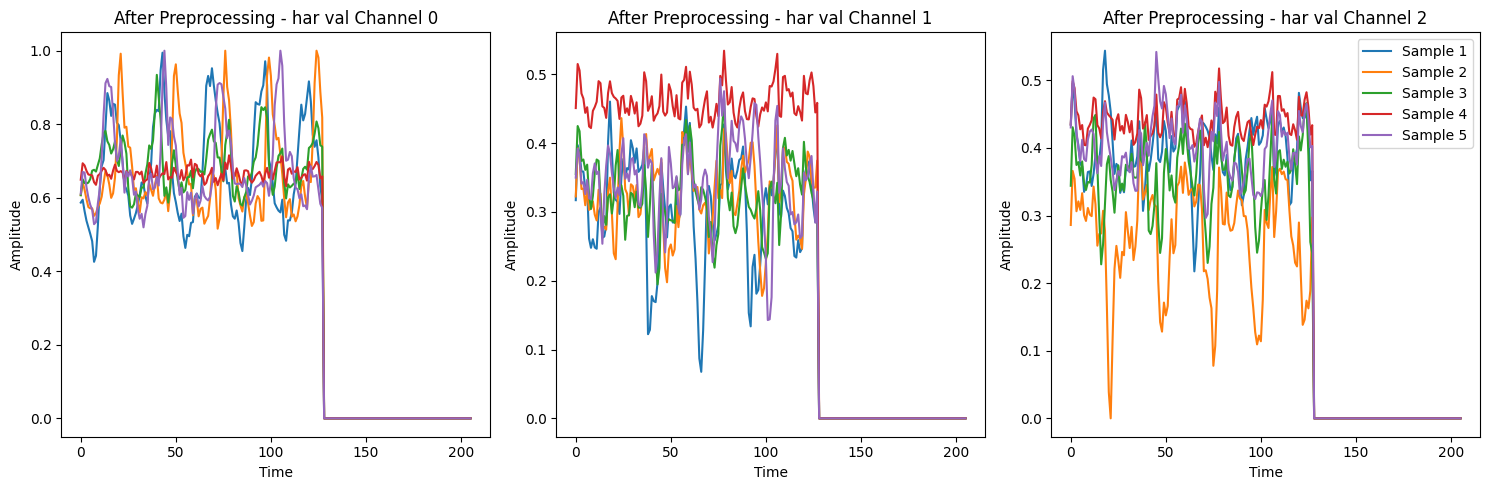

Visualizing gesture train data before and after preprocessing


<ipython-input-69-2b256814e937>:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  before_data = torch.load(filepaths[dataset_name][split])
<ipython-input-69-2b256814e937>:67

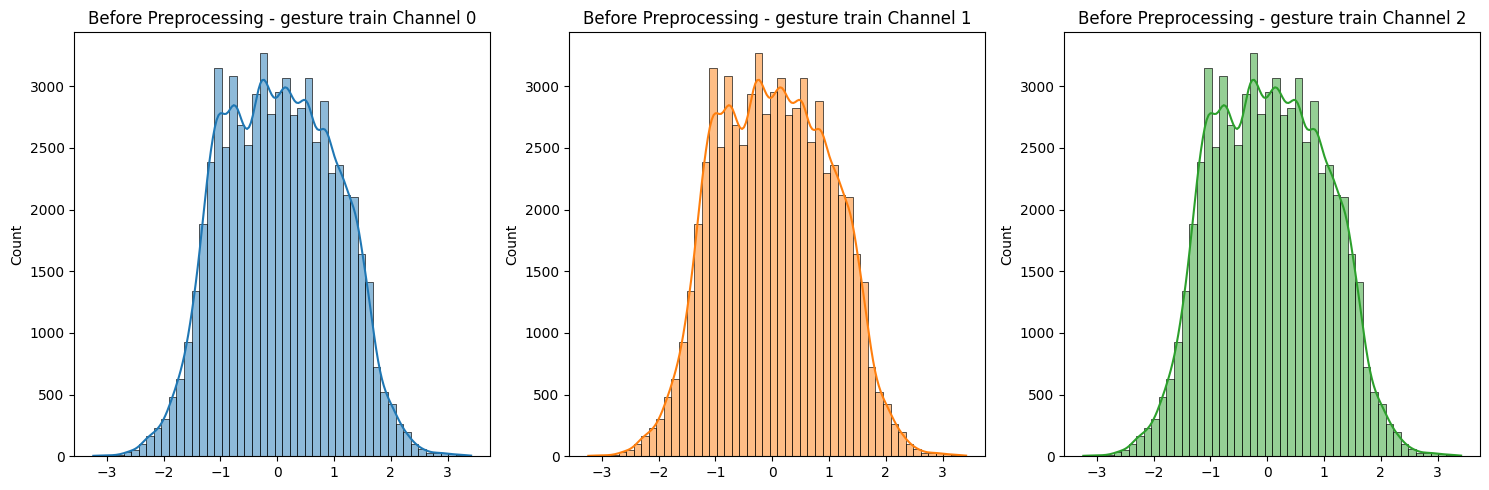

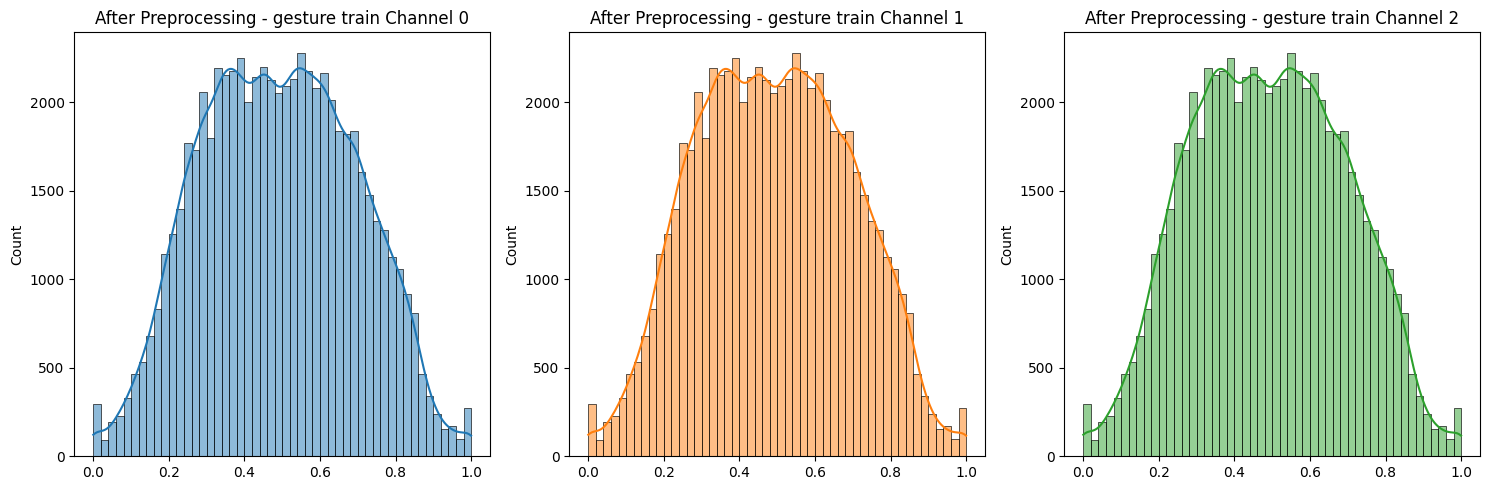

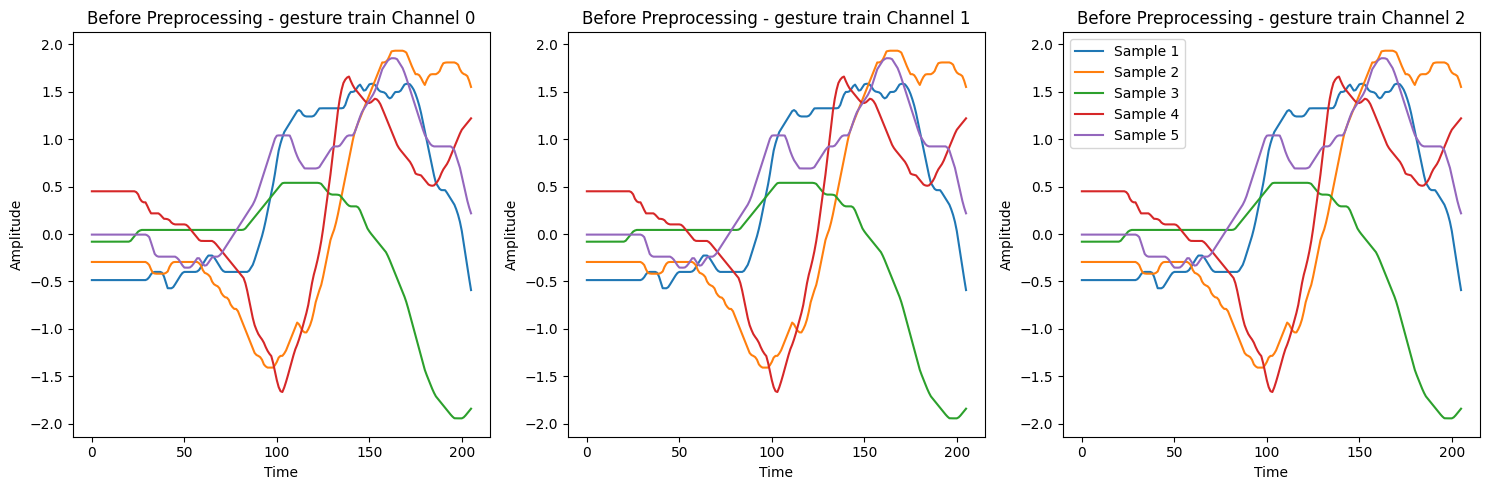

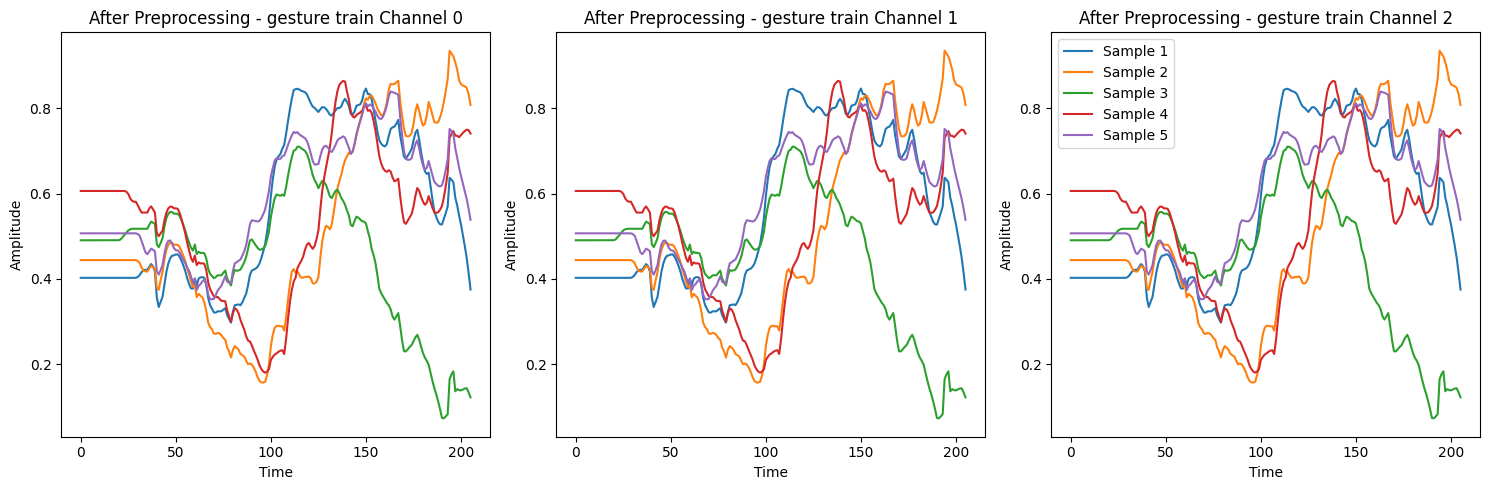

Visualizing gesture val data before and after preprocessing


<ipython-input-69-2b256814e937>:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  before_data = torch.load(filepaths[dataset_name][split])
<ipython-input-69-2b256814e937>:67

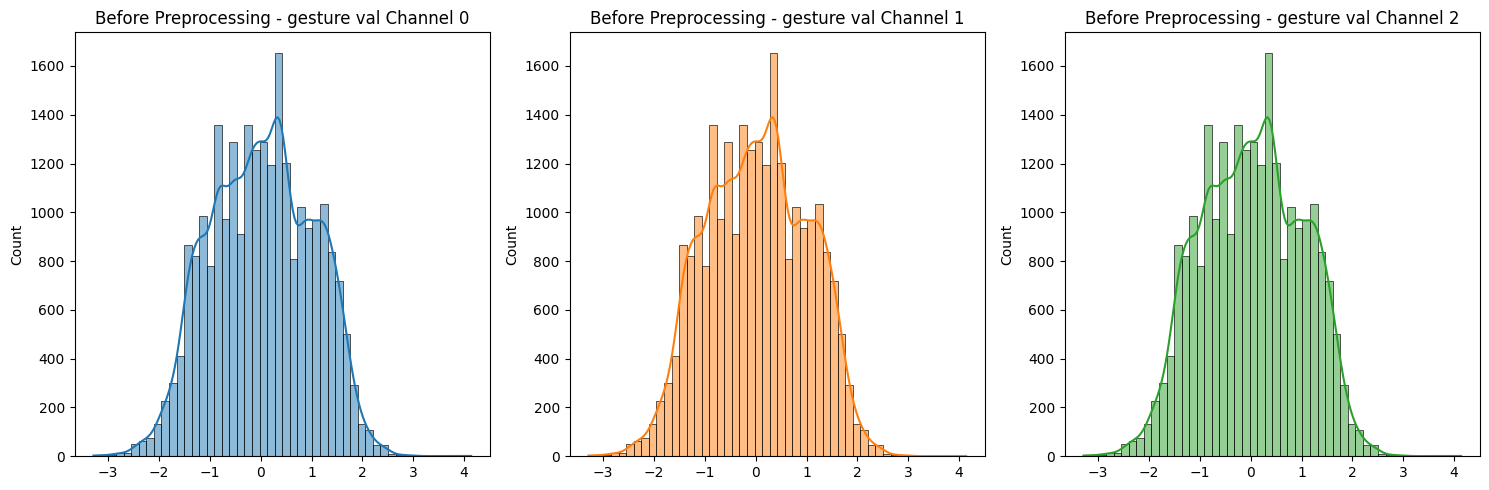

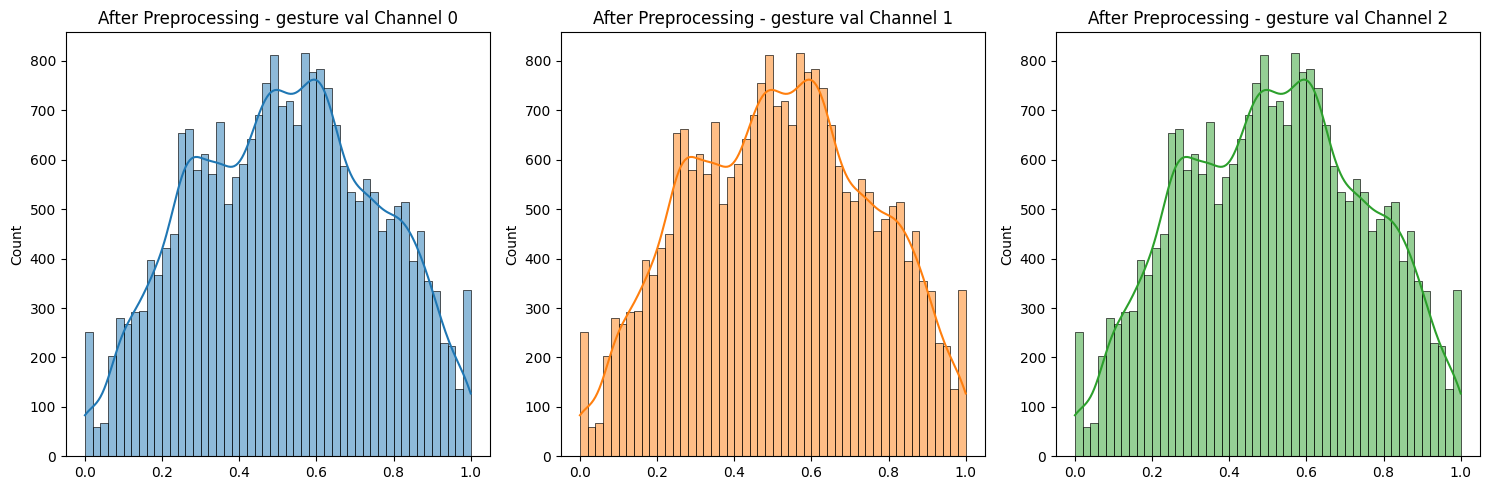

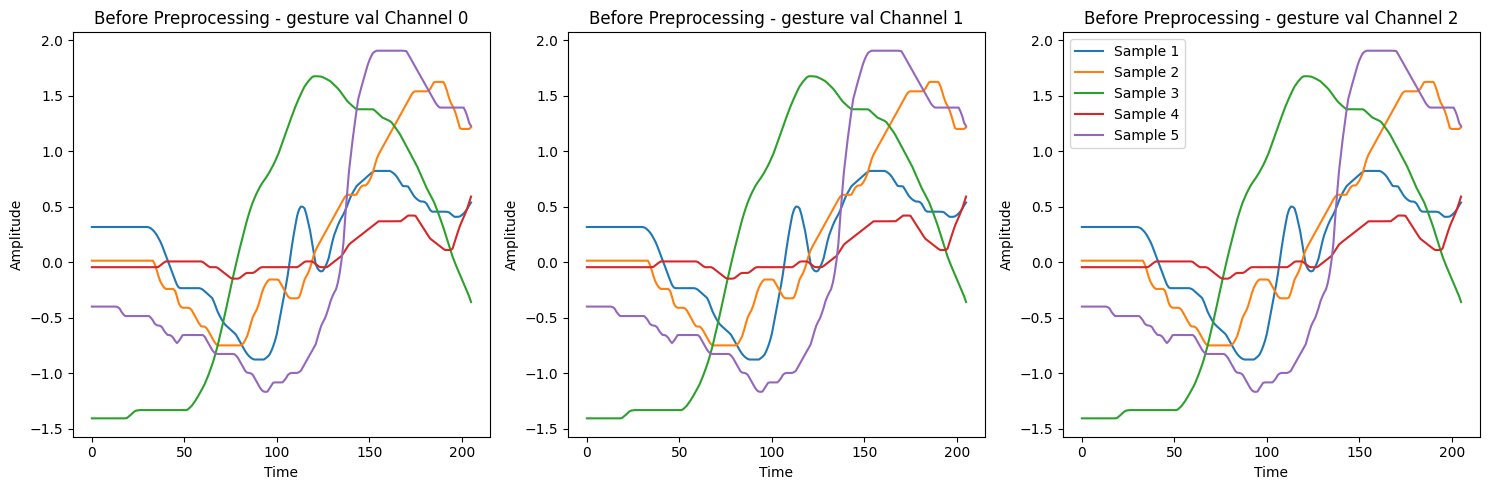

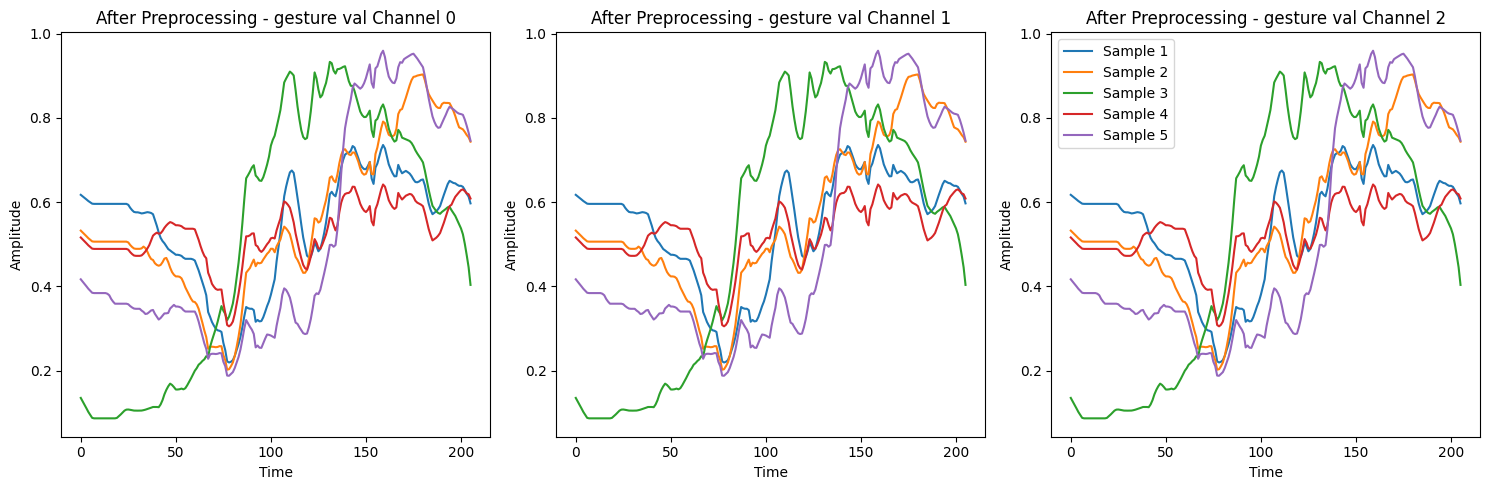

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot histograms for distribution
def plot_histogram(samples, title, dataset_name, split, channels=[0, 1, 2]):
    plt.figure(figsize=(15, 5))
    for i, channel in enumerate(channels):
        plt.subplot(1, 3, i+1)
        data = samples[:, channel, :].flatten().numpy()
        sns.histplot(data, kde=True, bins=50, color=f'C{i}')
        plt.title(f'{title} - {dataset_name} {split} Channel {channel}')
    plt.tight_layout()
    plt.show()

# Function to plot some time series samples (first 5 samples for example)
def plot_time_series(samples, title, dataset_name, split, channels=[0, 1, 2], num_samples=5):
    plt.figure(figsize=(15, 5))
    for i, channel in enumerate(channels):
        plt.subplot(1, 3, i+1)
        for j in range(num_samples):
            plt.plot(samples[j, channel, :].numpy(), label=f'Sample {j+1}')
        plt.title(f'{title} - {dataset_name} {split} Channel {channel}')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.legend()
    plt.show()

# Function to plot the difference between before and after preprocessing
def plot_comparison(before_samples, after_samples, dataset_name, split, channels=[0, 1, 2], num_samples=5):
    # Plot histograms for both before and after
    plot_histogram(before_samples, 'Before Preprocessing', dataset_name, split, channels)
    plot_histogram(after_samples, 'After Preprocessing', dataset_name, split, channels)

    # Plot time series data for both before and after
    plot_time_series(before_samples, 'Before Preprocessing', dataset_name, split, channels, num_samples)
    plot_time_series(after_samples, 'After Preprocessing', dataset_name, split, channels, num_samples)

# Filepaths for raw and preprocessed data
filepaths = {
    "har": {
        "train": "har/train.pt",
        "val": "har/val.pt",
        "train_preprocessed": "har/train_preprocessed.pt",
        "val_preprocessed": "har/val_preprocessed.pt"
    },
    "gesture": {
        "train": "gesture/train.pt",
        "val": "gesture/val.pt",
        "train_preprocessed": "gesture/train_preprocessed.pt",
        "val_preprocessed": "gesture/val_preprocessed.pt"
    }
}

# Function to load and visualize the data
def load_and_visualize_data():
    for dataset_name in filepaths:
        for split in ['train', 'val']:  # Checking train and val data only
            print(f'Visualizing {dataset_name} {split} data before and after preprocessing')

            # Load raw data (before preprocessing)
            before_data = torch.load(filepaths[dataset_name][split])
            before_samples = before_data['samples']

            # Load preprocessed data (after preprocessing)
            after_data = torch.load(filepaths[dataset_name][f'{split}_preprocessed'])
            after_samples = after_data['samples']

            # Plot comparison
            plot_comparison(before_samples, after_samples, dataset_name, split)

# Run the function to visualize the before and after preprocessing data
load_and_visualize_data()


## Preprocessing Analysis Report

### HAR Dataset:

#### Before preprocessing:
<li> Channels 0 and 1 had multimodal distributions with noise and outliers, which is common in real-world sensor data.
<li> Channel 2 had a unimodal distribution, but still with some noise and outliers.

#### After preprocessing:
<li> The multimodal distribution of Channels 0 and 1 was normalized, noise was reduced, and the underlying patterns were preserved, making the data more useful for modeling.
<li> Channel 2 showed a more focused distribution, with noise and outliers reduced, which will help in clearer model training.

### Gesture Dataset:

#### Before preprocessing:
The gesture data already had relatively normal distributions but contained some outliers.
#### After preprocessing:
The data became more focused, with the outliers reduced, which will make the model training more stable.
### Visual Analysis
<li> The histograms confirm the improvement in data quality. After preprocessing, the data distributions are cleaner, with reduced noise and outliers.
<li> The time series plots show the expected outcome: noise has been minimized, and the key patterns (both in HAR and Gesture datasets) are preserved, making them more suitable for modeling.

## Model Selection Overview

#### Objective
We aim to utilize Self-Supervised Learning (SSL) to improve the performance of classification models on time series data. We will implement Contrastive Learning for pretraining on the HAR dataset, followed by a classifier training and evaluation on both the HAR and Gesture datasets.

#### Why Contrastive Learning for Pretraining?

Contrastive Learning is a powerful self-supervised technique that learns useful feature representations without needing labeled data. The method works by bringing similar data points closer together in feature space and pushing dissimilar points apart. This is particularly beneficial for time series data, as it can capture subtle patterns, leading to robust features for downstream tasks like classification.

HAR Dataset: As an unlabeled dataset, HAR is suitable for self-supervised pretraining.
Gesture Dataset: After pretraining on HAR, we can transfer the learned representations to the Gesture dataset, which has labeled data for training and evaluation.


## Approach Overview
<ol>
<li> Contrastive Learning Pretraining on HAR:

Pretrain a neural network model using contrastive loss on the HAR dataset to learn meaningful representations from the raw time series data.
Why HAR?: It provides rich, unlabeled time series data for pretraining, enabling the model to learn generalized features useful for time series tasks.
<li> Train a Classifier on HAR Features:

After pretraining, use the learned features to train a classifier on the HAR training data.
Evaluation: Evaluate the model’s performance on the HAR test data to validate the learned representations.
<li> Transfer Knowledge to Gesture Dataset:

Use the pretrained model to extract features from the Gesture dataset.
Train a classifier on these features using Gesture training and validation data.
<li> Evaluate on Gesture Test Data:

Assess the classifier’s performance on the Gesture test data to see how well the features learned from HAR generalize to a different dataset.
</ol>

### Why this approach?
<li> Leveraging Unlabeled Data: Contrastive learning allows us to make use of the unlabeled HAR data for feature extraction, improving the model's performance on labeled datasets like Gesture.
<li> Transfer Learning: By transferring knowledge from HAR to Gesture, we aim to leverage the learned representations to enhance the performance of the classifier on the Gesture dataset, which might have less labeled data available.
<li> Simple Yet Powerful: Contrastive learning has shown great success in time series tasks, and by using it for pretraining, we enhance our classifier’s ability to recognize complex patterns in both datasets.

In [ ]:
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, samples, labels):
        self.samples = samples  # Time series data
        self.labels = labels    # Corresponding labels

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        label = self.labels[idx]
        return sample, label


In [ ]:
from torch.utils.data import DataLoader

har_train = torch.load('har/train_preprocessed.pt')
har_val = torch.load('har/val_preprocessed.pt')
# Initialize the dataset for training and validation
train_dataset = TimeSeriesDataset(har_train['samples'], har_train['labels'])
val_dataset = TimeSeriesDataset(har_val['samples'], har_val['labels'])

# Define the DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Check if the DataLoader works as expected by iterating through it
for data, label in train_loader:
    print(f"Data: {data.shape}, Label: {label.shape}")
    break  # just print the first batch


Data: torch.Size([32, 3, 206]), Label: torch.Size([32])


<ipython-input-71-a4eee6bae27e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  har_train = torch.load('har/train_preprocessed.pt')
<ipython-input-71-a4eee6bae27e>:4: Futur

In [ ]:
'''
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import time

# Paths to save checkpoints and results
CHECKPOINT_PATH = './checkpoints'
os.makedirs(CHECKPOINT_PATH, exist_ok=True)
RESULTS_PATH = './training_results.csv'

# Dataset Definition
class TimeSeriesDataset(Dataset):
    def __init__(self, samples, labels):
        self.samples = samples
        self.labels = labels

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

# Data Loading
har_train = torch.load('har/train_preprocessed.pt')
har_val = torch.load('har/val_preprocessed.pt')

train_dataset = TimeSeriesDataset(har_train['samples'], har_train['labels'])
val_dataset = TimeSeriesDataset(har_val['samples'], har_val['labels'])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# LSTM Encoder
class LSTMEncoder(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, output_size=64, num_layers=2):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = torch.pairwise_distance(output1, output2)
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                          label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss

# Training Loop
def train_contrastive_model(train_loader, model, loss_fn, optimizer, num_epochs=5, save_interval=2):
    model.train()
    results = []
    start_time = time.time()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for data1, labels in train_loader:
            data1 = data1.permute(0, 2, 1)
            data2 = data1[torch.randperm(data1.size(0))]

            output1 = model(data1)
            output2 = model(data2)

            loss = loss_fn(output1, output2, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = torch.norm(output1 - output2, p=2, dim=1)
            correct += (pred < 1).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        results.append({"epoch": epoch + 1, "loss": epoch_loss, "accuracy": epoch_accuracy})

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

        if (epoch + 1) % save_interval == 0:
            checkpoint_file = os.path.join(CHECKPOINT_PATH, f'checkpoint_epoch_{epoch+1}.pth')
            torch.save(model.state_dict(), checkpoint_file)
            print(f"Checkpoint saved at {checkpoint_file}")

    # Save results to CSV
    pd.DataFrame(results).to_csv(RESULTS_PATH, index=False)
    print(f"Training completed in {time.time() - start_time:.2f}s. Results saved to {RESULTS_PATH}.")

# Transfer Learning for Gesture Dataset
def transfer_and_train_classifier(gesture_train, gesture_test, encoder):
    encoder.eval()  # Use pretrained encoder
    classifier = nn.Sequential(
        encoder,
        nn.Linear(64, 10)  # Adjust output for 10 classes in Gesture dataset
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

    # Training Logic similar to above, adjusted for classification
    # ...
    # Evaluation Logic for Gesture Test Set
    # ...

# Initialize and Start Training
model = LSTMEncoder(input_size=3, hidden_size=128, output_size=64, num_layers=2)
loss_fn = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train model with limited epochs due to time constraint
train_contrastive_model(train_loader, model, loss_fn, optimizer, num_epochs=3, save_interval=1)
'''

'\nimport torch\nimport torch.nn as nn\nfrom torch.utils.data import Dataset, DataLoader\nimport os\nimport pandas as pd\nimport time\n\n# Paths to save checkpoints and results\nCHECKPOINT_PATH = \'./checkpoints\'\nos.makedirs(CHECKPOINT_PATH, exist_ok=True)\nRESULTS_PATH = \'./training_results.csv\'\n\n# Dataset Definition\nclass TimeSeriesDataset(Dataset):\n    def __init__(self, samples, labels):\n        self.samples = samples\n        self.labels = labels\n\n    def __len__(self):\n        return len(self.samples)\n\n    def __getitem__(self, idx):\n        return self.samples[idx], self.labels[idx]\n\n# Data Loading\nhar_train = torch.load(\'har/train_preprocessed.pt\')\nhar_val = torch.load(\'har/val_preprocessed.pt\')\n\ntrain_dataset = TimeSeriesDataset(har_train[\'samples\'], har_train[\'labels\'])\nval_dataset = TimeSeriesDataset(har_val[\'samples\'], har_val[\'labels\'])\n\nbatch_size = 32\ntrain_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)\nval_l

In [ ]:
#torch.save(train_contrastive_model,"train_contrastive_model.pth")

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import os
import pandas as pd
import time

# Dataset and DataLoader Setup
class TimeSeriesDataset(Dataset):
    def __init__(self, samples, labels):
        self.samples = samples
        self.labels = labels

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        label = self.labels[idx]
        return sample, label

har_train = torch.load('har/train_preprocessed.pt')
train_dataset = TimeSeriesDataset(har_train['samples'], har_train['labels'])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define Autoencoder Architecture
class Autoencoder(nn.Module):
    def __init__(self, input_size=3, seq_length=206, latent_dim=64):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size * seq_length, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_size * seq_length),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Flatten input for encoder
        x = x.reshape(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        # Reshape output to match input shape
        decoded = decoded.view(x.size(0), -1, 3)
        return decoded, encoded

import torch
import time

def train_autoencoder(train_loader, model, criterion, optimizer, num_epochs=5, threshold=0.01):
    model.train()
    print("Training Autoencoder...")
    start_time = time.time()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_reconstruction = 0
        total = 0

        for data, _ in train_loader:
            # Ensure data is in the correct shape for LSTM: [batch_size, seq_length, input_size]
            data = data.permute(0, 2, 1)  # [batch_size, 3, 206] => [batch_size, 206, 3]

            # Forward pass
            reconstructed, _ = model(data)
            loss = criterion(reconstructed, data)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy (using a threshold for reconstruction error)
            # Find the reconstruction error (e.g., L2 distance or simple absolute difference)
            reconstruction_error = torch.abs(reconstructed - data)  # L1 error (absolute)
            correct_reconstruction += (reconstruction_error < threshold).sum().item()  # Count correct reconstructions
            total += data.numel()  # Count total number of elements

        avg_loss = running_loss / len(train_loader)
        reconstruction_accuracy = correct_reconstruction / total

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Reconstruction Accuracy: {reconstruction_accuracy:.4f}")

    print(f"Autoencoder training completed in {time.time() - start_time:.2f} seconds.")
    return model


<ipython-input-74-91517c7aafa1>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  har_train = torch.load('har/train_preprocessed.pt')


In [ ]:
# Define the model, loss function, and optimizer
model = Autoencoder(input_size=3, seq_length=206, latent_dim=64)
criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
model = train_autoencoder(train_loader, model, criterion, optimizer, num_epochs=10)


Training Autoencoder...
Epoch 1/10, Loss: 0.0070, Reconstruction Accuracy: 0.4308
Epoch 2/10, Loss: 0.0014, Reconstruction Accuracy: 0.5946
Epoch 3/10, Loss: 0.0012, Reconstruction Accuracy: 0.6349
Epoch 4/10, Loss: 0.0012, Reconstruction Accuracy: 0.6524
Epoch 5/10, Loss: 0.0009, Reconstruction Accuracy: 0.6773
Epoch 6/10, Loss: 0.0009, Reconstruction Accuracy: 0.6886
Epoch 7/10, Loss: 0.0009, Reconstruction Accuracy: 0.6881
Epoch 8/10, Loss: 0.0008, Reconstruction Accuracy: 0.7008
Epoch 9/10, Loss: 0.0007, Reconstruction Accuracy: 0.7055
Epoch 10/10, Loss: 0.0007, Reconstruction Accuracy: 0.7104
Autoencoder training completed in 27.21 seconds.


In [ ]:
torch.save(model,"autoencoder.pth")

In [ ]:
# Assuming you have test data in 'har_test' similar to 'har_train'
# If 'har_test' is not already loaded, load it similarly
har_test = torch.load('har/test.pt')  # Replace with the correct path

# Create a dataset for the test set
test_dataset = TimeSeriesDataset(har_test['samples'], har_test['labels'])

# Create DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Now you can extract latent features for the test set
test_features, test_labels = extract_latent_features(autoencoder, test_loader)


<ipython-input-77-4341a9ba368b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  har_test = torch.load('har/test.pt')  # Replace with the correct path


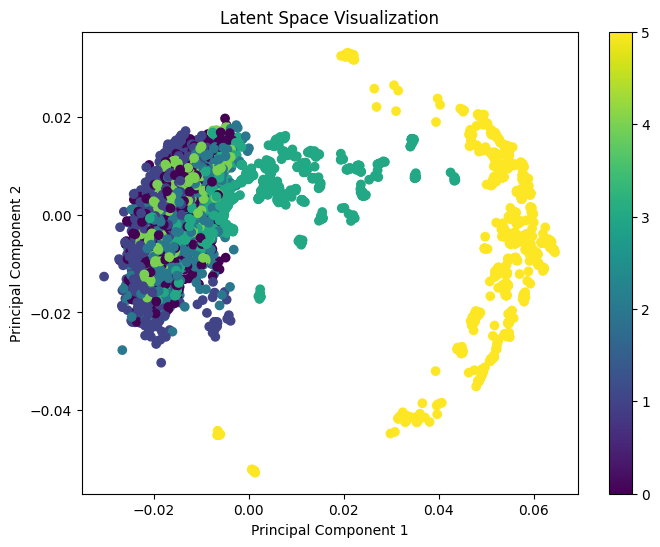

In [ ]:
from sklearn.decomposition import PCA
import torch
import matplotlib.pyplot as plt

def extract_latent_features(autoencoder, data_loader):
    autoencoder.eval()  # Set the model to evaluation mode
    features = []
    labels = []
    with torch.no_grad():
        for data, label in data_loader:
            data = data.view(data.size(0), -1)  # Flatten the input for the encoder
            encoded_features, _ = autoencoder(data)  # Only extract the encoded features
            features.append(encoded_features)
            labels.append(label)
    return torch.cat(features), torch.cat(labels)

# Extract latent features for both training and test data
train_features, train_labels = extract_latent_features(autoencoder, train_loader)
test_features, test_labels = extract_latent_features(autoencoder, test_loader)

# Flatten the features to 2D (samples x latent_dim)
train_features = train_features.view(train_features.size(0), -1)
test_features = test_features.view(test_features.size(0), -1)

# Perform PCA on the train features (to reduce to 2 dimensions for visualization)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(train_features.detach().numpy())  # Use only train features for fitting

# Plot the latent features in 2D space
plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=train_labels, cmap='viridis')
plt.colorbar()  # Show color bar to indicate class labels
plt.title("Latent Space Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


## Analyzing the Latent Space Visualization and Training Results
Summary of our Observations:
<ol><li>Distinct Clusters: The fact that you see distinct clusters suggests that the autoencoder is learning to differentiate between different types of data. This is a good indication that the latent space is capturing meaningful patterns.

<li>Cluster Separation: The separation between clusters indicates that the model is able to map similar data points close to each other in the latent space, which is an important property for tasks like classification and anomaly detection.

<li>Color Coding: If the color coding represents different class labels, and similar colored points cluster together, it suggests that the autoencoder is preserving class information within the latent space. This could make it easier for downstream models to classify the data based on these representations.</ol>

In [ ]:
import torch
import torch.nn.functional as F

class NT_XentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NT_XentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        # Normalize the features
        z_i = F.normalize(z_i, dim=-1, p=2)
        z_j = F.normalize(z_j, dim=-1, p=2)

        # Compute cosine similarity between z_i and z_j
        sim = torch.matmul(z_i, z_j.T) / self.temperature
        labels = torch.arange(z_i.size(0)).to(z_i.device)  # Diagonal is the similarity for positive pairs

        loss = F.cross_entropy(sim, labels)
        return loss


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Define the SimCLR model
class SimCLR(nn.Module):
    def __init__(self, backbone, projection_dim=128):
        super(SimCLR, self).__init__()
        self.backbone = backbone

        # Get the number of input features from the last fully connected layer of the backbone
        in_features = self.backbone.fc.in_features

        # Remove the final classification layer (fully connected layer)
        self.backbone.fc = torch.nn.Identity()

        # Projection head
        self.projection_head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, projection_dim)
        )

    def forward(self, x):
        # Extract features from the backbone (excluding the final classification layer)
        features = self.backbone(x)

        # Apply projection head
        projections = self.projection_head(features)
        return projections

# Load pre-trained ResNet18 model
backbone = models.resnet18(pretrained=True)

# Create the SimCLR model (passing the backbone)
model = SimCLR(backbone)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Train a RandomForest classifier on the extracted latent features
from sklearn.svm import SVC
classifier = SVC(kernel='linear')  # You can experiment with different kernels
classifier.fit(train_features_np, train_labels_np)


# Evaluate the model on the test set
test_predictions = clf.predict(test_features.numpy())

# Print classification report and confusion matrix
print("Classification Report on Test Set:")
print(classification_report(test_labels.numpy(), test_predictions))

print("Confusion Matrix on Test Set:")
print(confusion_matrix(test_labels.numpy(), test_predictions))


Classification Report on Test Set:
              precision    recall  f1-score   support

         0.0       0.07      0.01      0.01       496
         1.0       0.19      0.21      0.20       471
         2.0       0.19      0.85      0.31       420
         3.0       0.00      0.00      0.00       491
         4.0       0.00      0.00      0.00       532
         5.0       1.00      0.95      0.97       537

    accuracy                           0.33      2947
   macro avg       0.24      0.34      0.25      2947
weighted avg       0.25      0.33      0.26      2947

Confusion Matrix on Test Set:
[[  3  93 400   0   0   0]
 [  2 100 369   0   0   0]
 [  3  62 355   0   0   0]
 [ 34 167 290   0   0   0]
 [  4 116 412   0   0   0]
 [  0   0  27   0   0 510]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Load the gesture dataset (replace with the correct path if needed)
gesture_data = torch.load('gesture/train.pt')
gesture_dataset = TimeSeriesDataset(gesture_data['samples'], gesture_data['labels'])
gesture_loader = DataLoader(gesture_dataset, batch_size=batch_size, shuffle=False)


<ipython-input-93-41dbd4bc27b1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gesture_data = torch.load('gesture/train.pt')


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Assume Autoencoder is already defined and loaded as `autoencoder`
# Modify the extract_latent_features function to ensure the data type is correct

def extract_latent_features(autoencoder, data_loader):
    autoencoder.eval()  # Set the model to evaluation mode
    features = []
    labels = []
    with torch.no_grad():  # Disable gradient computation for feature extraction
        for data, label in data_loader:
            # Ensure data is of type float32 (the expected type for the model)
            data = data.float()  # Convert the data to float32
            data = data.view(data.size(0), -1)  # Flatten the input for the encoder

            # Extract features from the autoencoder (using the encoder part)
            encoded_features, _ = autoencoder(data)  # Only extract the encoded features
            features.append(encoded_features)
            labels.append(label)

    # Return the features and labels
    return torch.cat(features), torch.cat(labels)


In [ ]:
# Assume you have a gesture dataset (e.g., gesture_samples and gesture_labels)
# You need to load the gesture data into a DataLoader

gesture_dataset = TimeSeriesDataset(gesture_samples, gesture_labels)  # Define TimeSeriesDataset as before
gesture_loader = DataLoader(gesture_dataset, batch_size=32, shuffle=False)

# Now, extract the latent features from the gesture dataset
gesture_features, gesture_labels = extract_latent_features(autoencoder, gesture_loader)

# Convert features to numpy arrays (as the classifier expects numpy arrays)
gesture_features_np = gesture_features.view(gesture_features.size(0), -1).numpy()  # Flatten the features
gesture_labels_np = gesture_labels.numpy()


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Train an SVM classifier on the extracted features from gesture data
classifier = SVC(kernel='linear')  # You can try other kernels (e.g., 'rbf', 'poly')
classifier.fit(gesture_features_np, gesture_labels_np)

# Evaluate the model on the test set (you can also evaluate on validation set, but here using the test set)
test_predictions = classifier.predict(gesture_features_np)

# Print classification report and confusion matrix
print("Classification Report on Gesture Test Set:")
print(classification_report(gesture_labels_np, test_predictions))

print("Confusion Matrix on Gesture Test Set:")
print(confusion_matrix(gesture_labels_np, test_predictions))


Classification Report on Gesture Test Set:
              precision    recall  f1-score   support

         0.0       0.55      0.70      0.62        40
         1.0       0.62      0.85      0.72        40
         2.0       0.61      0.90      0.73        40
         3.0       0.48      0.85      0.61        40
         4.0       0.00      0.00      0.00        40
         5.0       0.50      0.05      0.09        40
         6.0       0.70      0.57      0.63        40
         7.0       0.66      0.72      0.69        40

    accuracy                           0.58       320
   macro avg       0.51      0.58      0.51       320
weighted avg       0.51      0.58      0.51       320

Confusion Matrix on Gesture Test Set:
[[28  6  0  1  1  1  2  1]
 [ 1 34  1  0  0  1  2  1]
 [ 1  0 36  0  0  0  3  0]
 [ 1  2  0 34  0  0  0  3]
 [ 2  5  7 17  0  0  3  6]
 [ 6  5 11 12  0  2  0  4]
 [ 7  3  4  1  2  0 23  0]
 [ 5  0  0  6  0  0  0 29]]


## Key Insights from the Gesture Test Set Classification:
### Overall Accuracy:
The model achieved an accuracy of 58% on the gesture test set. While decent, there is room for improvement in handling specific classes.

#### Strong Class Performance:

Class 0, 1, 2, 3, and 7 performed relatively well, with f1-scores ranging from 0.61 to 0.73.
These classes show good balance between precision and recall, suggesting that the model captures these patterns effectively.
#### Weak Class Performance:

Class 4 and 5 showed poor performance, with f1-scores near 0. This indicates that the model struggles to distinguish these classes, likely due to insufficient latent space representation or overlap with other classes.
Confusion Observations:

Class 4 was frequently misclassified as Class 3 or 7, showing a lack of clear boundary in the latent space.
Class 5 showed significant misclassification across multiple classes, which highlights instability in recognizing this class.
Cluster Interpretation:
The confusion matrix suggests that some classes (e.g., 4, 5) may need further refinement in the latent space to better separate their patterns.

## Conclusion:
While the model demonstrates moderate success with several gesture classes, performance on others indicates potential improvements:

<li> Focus on fine-tuning the autoencoder or latent space.
<li> Use of contrastive learning to improve separation for underperforming classes.